# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [26]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

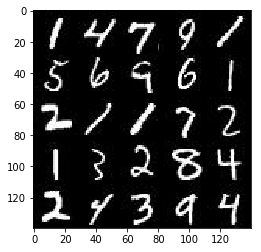

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

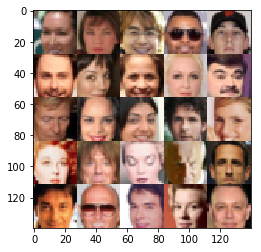

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [30]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='input_z')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/demo/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/demo/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", 

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [67]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #28x28x3 ---> 14, 14, 32 ---> 7, 7, 64 ----> 4, 4, 128 ---> 4*4*128
    alpha = 0.2
    keep_prob = 1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dp2 = tf.nn.dropout(relu2, keep_prob)
        #7x7x64
        
        x3 = tf.layers.conv2d(dp2, 128, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dp3 = tf.nn.dropout(relu3, keep_prob)
        #4x4x128
                        
        flat = tf.reshape(dp3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #1

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [73]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #reuse_param=True 
    alpha = 0.2
    keep_prob = 1
    #4*4*128 ---> 4, 4, 128 ---> 7, 7, 64 ---> 14, 14, 32 ---> 28x28x3
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*128)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        dp2 = tf.nn.dropout(x2, keep_prob)
        # 7x7x64 now
        
        x3 = tf.layers.conv2d_transpose(dp2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        dp3 = tf.nn.dropout(x3, keep_prob)
        # 14x14x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(dp3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [74]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [75]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [79]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # scaling the batch images by a factor of 2 to make it in the range of [-1 1]
                batch_images = batch_images * 2
                steps+=1
        
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr:learning_rate, input_real:batch_images})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0579... Generator Loss: 8.9093


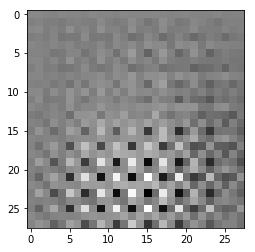

Epoch 1/2... Discriminator Loss: 0.0482... Generator Loss: 4.8732


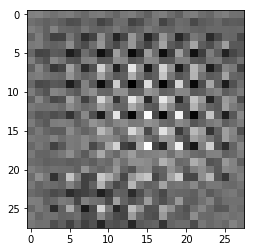

Epoch 1/2... Discriminator Loss: 0.0236... Generator Loss: 5.9710


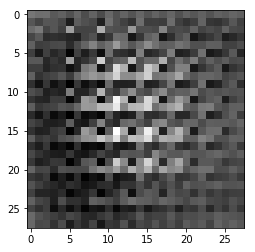

Epoch 1/2... Discriminator Loss: 0.2921... Generator Loss: 1.9490


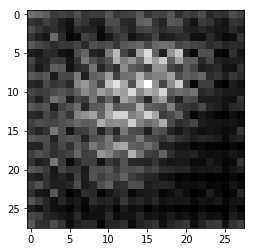

Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 3.1104


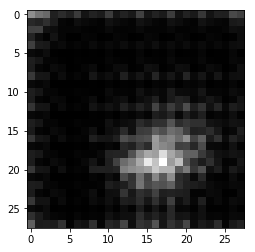

Epoch 1/2... Discriminator Loss: 0.2822... Generator Loss: 3.1784


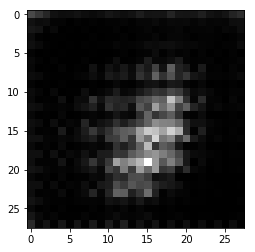

Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.3278


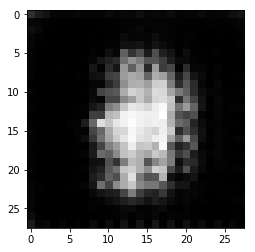

Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.1367


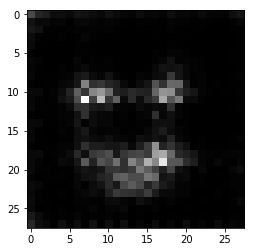

Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 2.5490


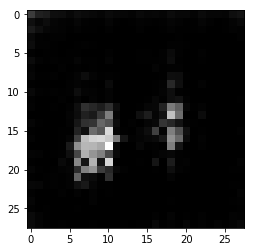

Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.8440


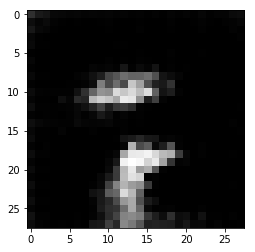

Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 1.2624


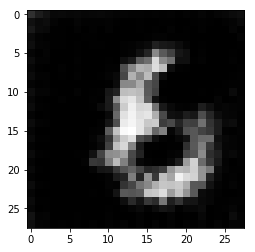

Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 0.6059


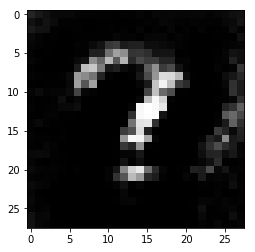

Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.2576


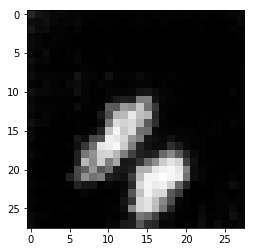

Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.3744


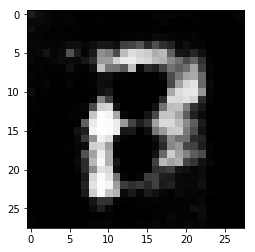

Epoch 1/2... Discriminator Loss: 0.4273... Generator Loss: 2.1129


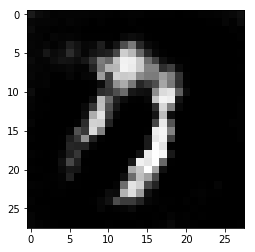

Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 1.3124


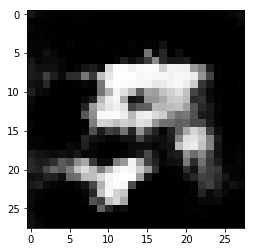

Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 1.4548


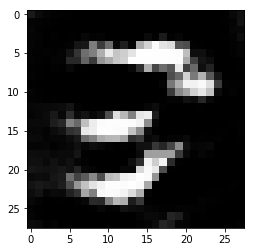

Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.8067


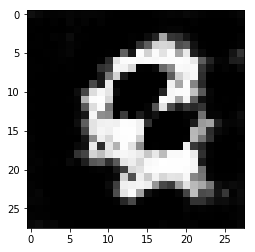

Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 1.1196


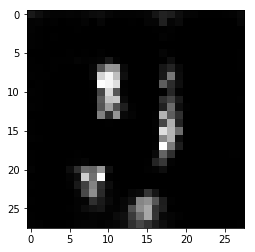

Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.8056


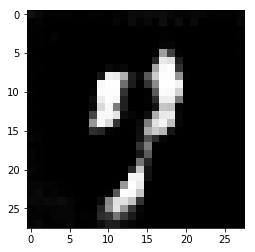

Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.7952


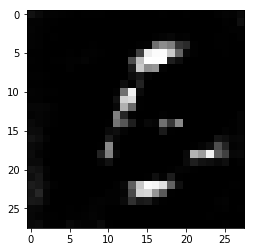

Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 1.3723


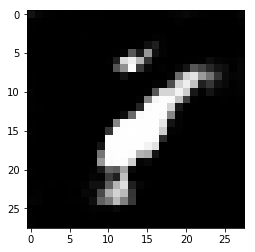

Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 0.8635


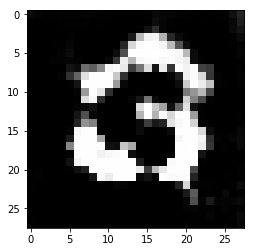

Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.5644


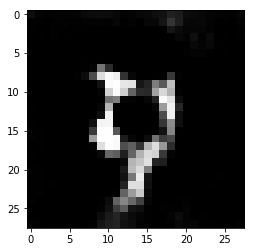

Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 2.1495


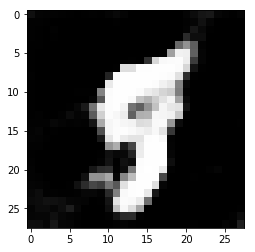

Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 0.9319


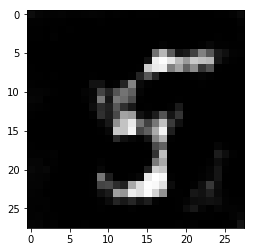

Epoch 1/2... Discriminator Loss: 2.3896... Generator Loss: 0.1340


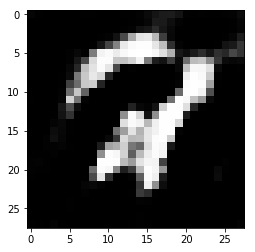

Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 1.4769


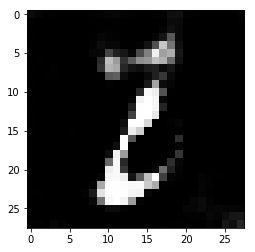

Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.5991


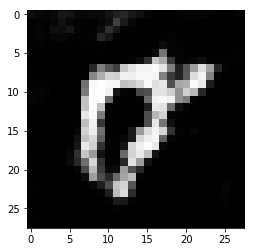

Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 1.1627


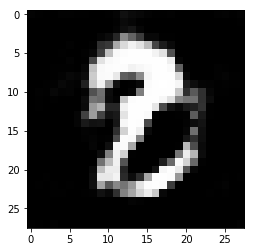

Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.8629


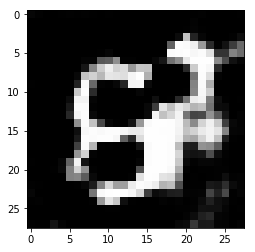

Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.9680


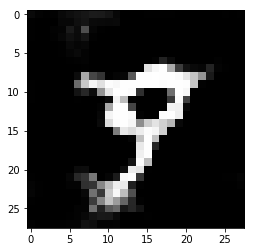

Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.7534


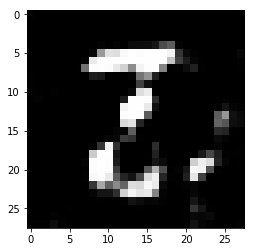

Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.4640


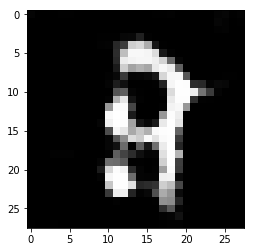

Epoch 1/2... Discriminator Loss: 1.5293... Generator Loss: 0.3595


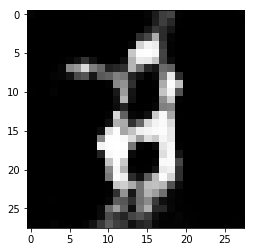

Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 0.8727


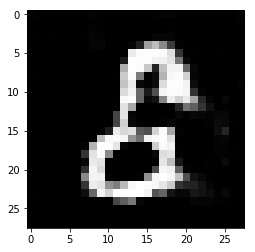

Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 1.5097


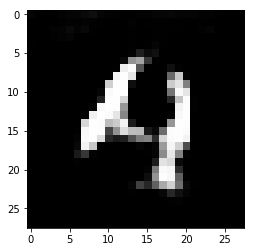

Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.5567


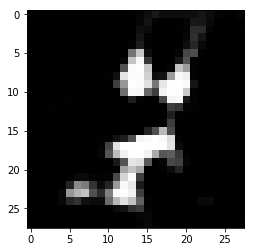

Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.1982


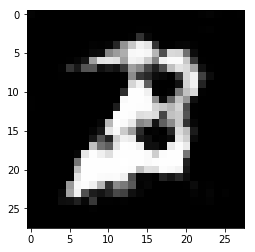

Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.3716


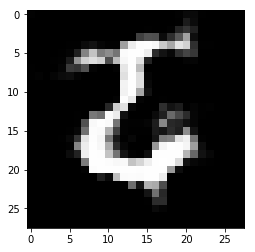

Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.9414


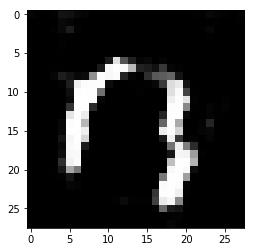

Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.6247


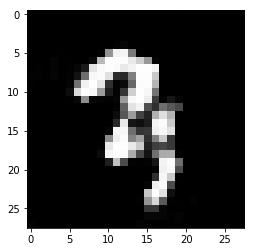

Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.1083


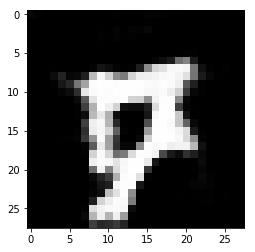

Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 1.5892


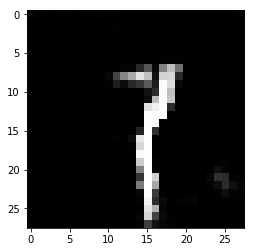

Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.7757


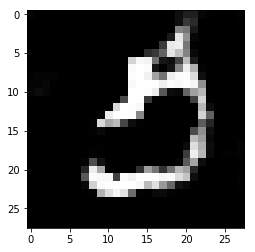

Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 1.0341


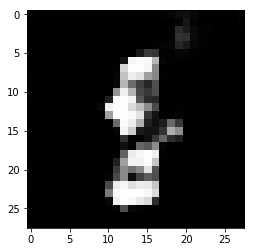

Epoch 1/2... Discriminator Loss: 1.5601... Generator Loss: 0.4234


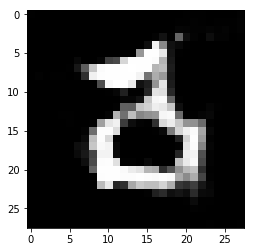

Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 1.3225


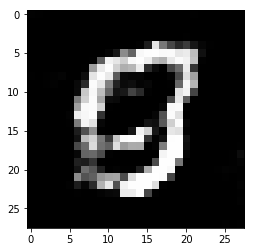

Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 0.6588


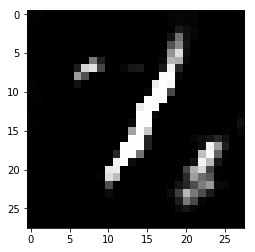

Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.0849


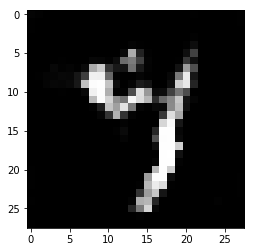

Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.1853


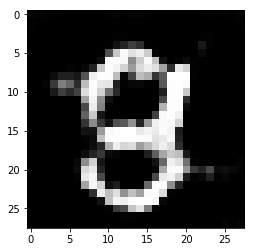

Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.4762


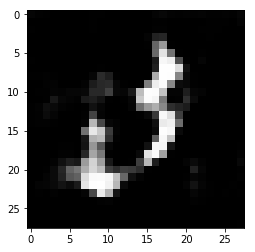

Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.1064


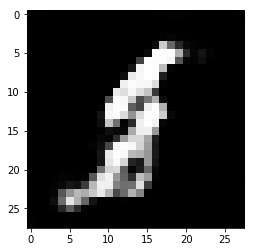

Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.5256


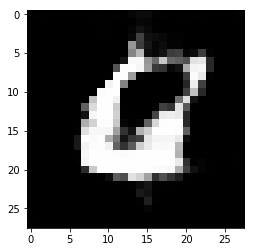

Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.5398


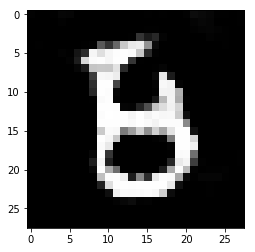

Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.7317


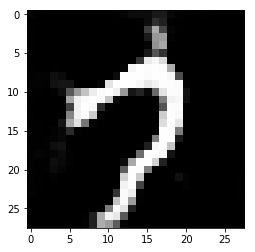

Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 1.4230


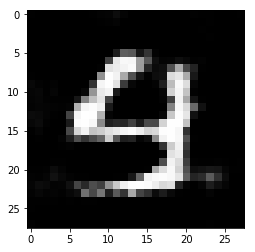

Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 0.8978


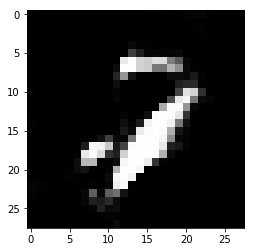

Epoch 1/2... Discriminator Loss: 2.1772... Generator Loss: 2.5441


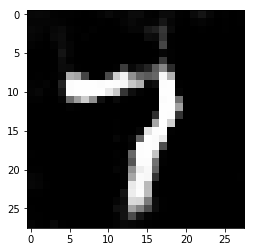

Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 0.8894


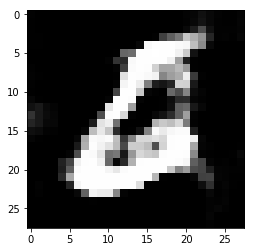

Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.6372


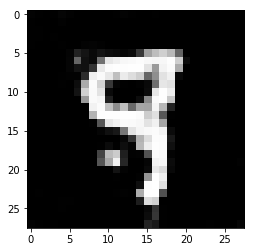

Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.4221


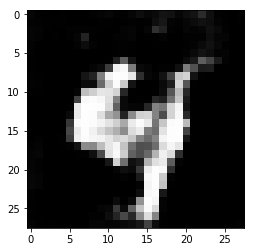

Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.5036


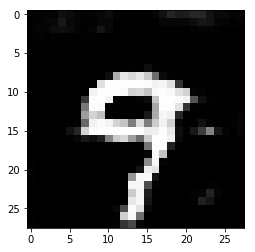

Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 0.9864


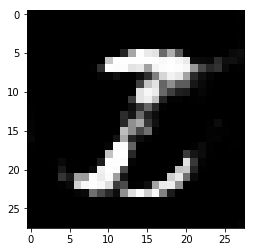

Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 1.2105


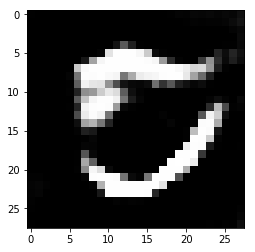

Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 0.3617


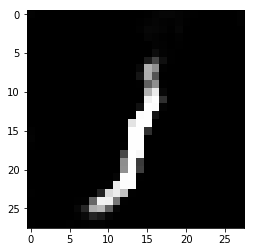

Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 1.0377


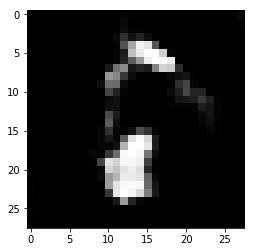

Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.4119


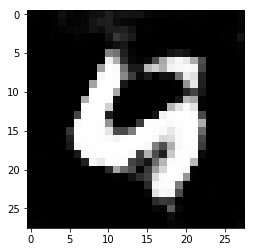

Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.5581


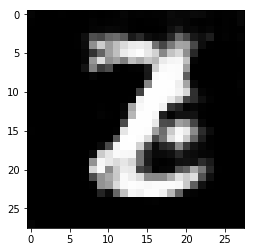

Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 1.3762


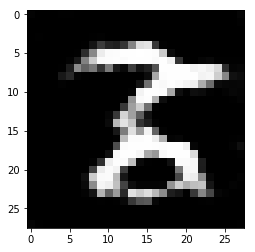

Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 2.2625


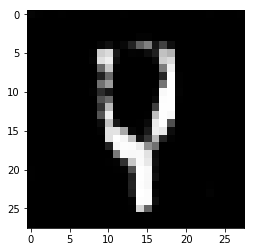

Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 0.9053


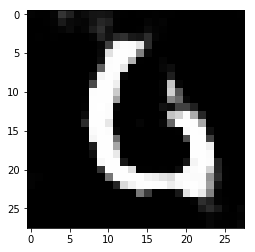

Epoch 1/2... Discriminator Loss: 1.6600... Generator Loss: 0.3161


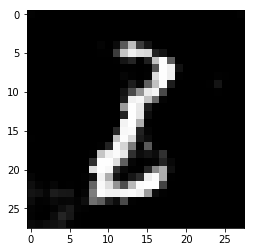

Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 0.9269


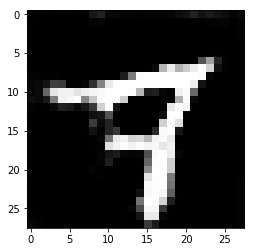

Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 0.9052


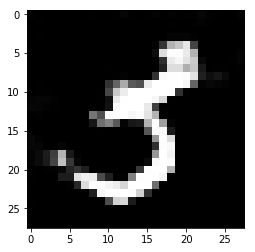

Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 0.9448


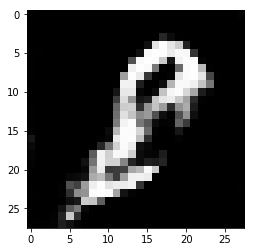

Epoch 1/2... Discriminator Loss: 0.8115... Generator Loss: 1.4137


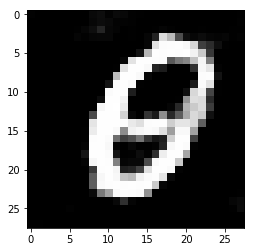

Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.6483


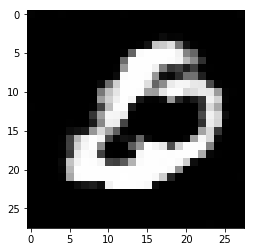

Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.7151


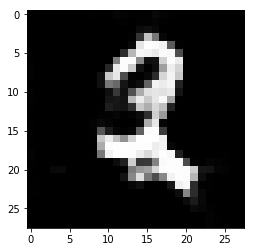

Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.5856


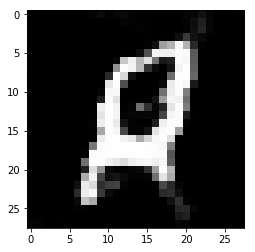

Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 1.0486


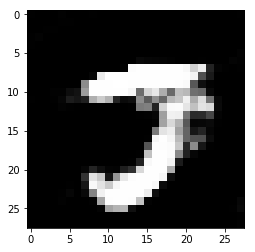

Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.1480


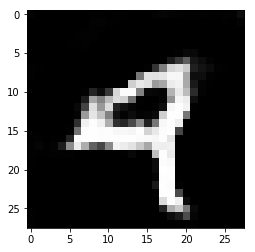

Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 0.6869


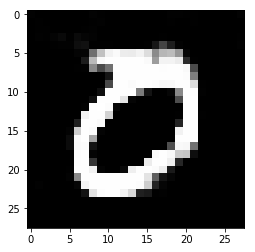

Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.4814


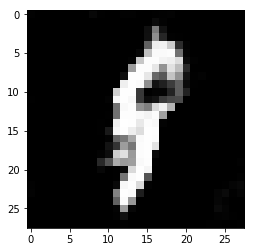

Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 0.7621


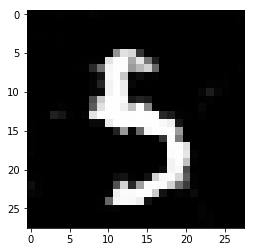

Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 1.3436


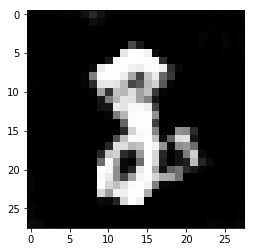

Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 1.1781


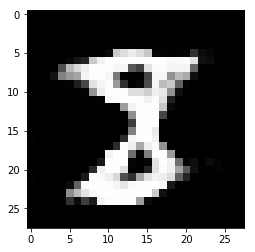

Epoch 1/2... Discriminator Loss: 1.7487... Generator Loss: 0.2719


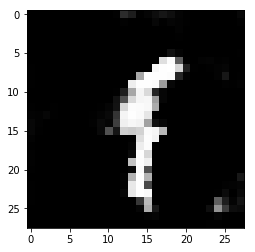

Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 0.8780


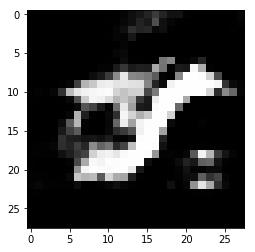

Epoch 1/2... Discriminator Loss: 1.8057... Generator Loss: 0.2400


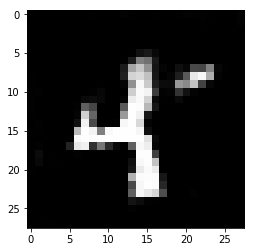

Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 0.8978


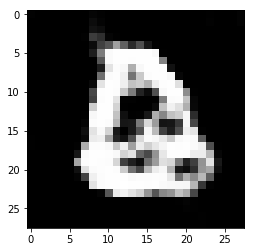

Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 0.7675


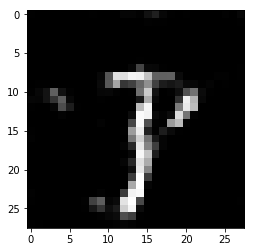

Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 0.9889


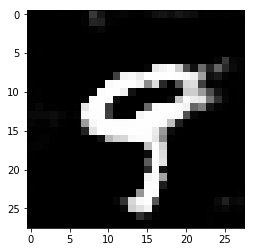

Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 1.9235


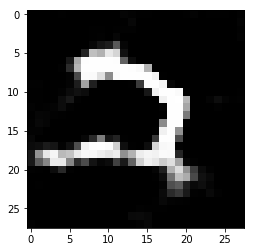

Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.1035


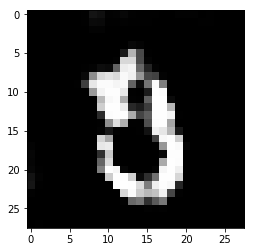

Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.9943


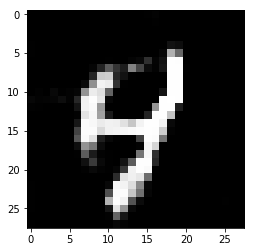

Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.5309


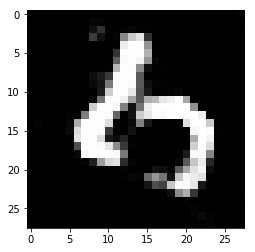

Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.2630


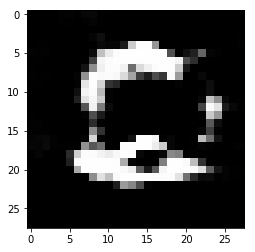

Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.6258


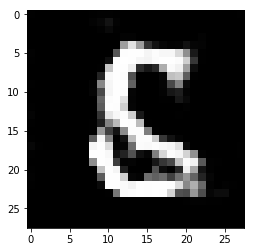

Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.6416


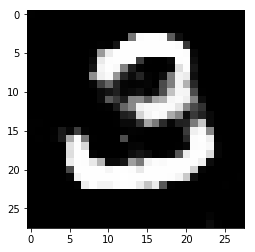

Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 0.8654


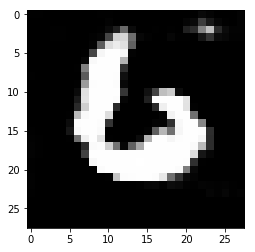

Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.6878


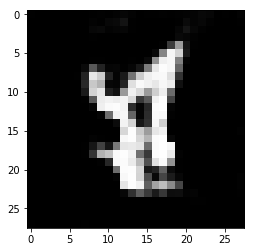

Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.6442


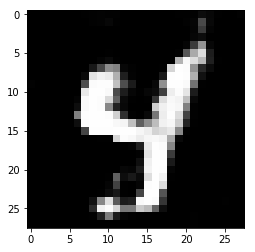

Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.1046


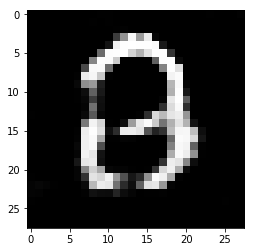

Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 1.5808


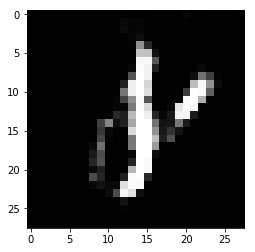

Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.0772


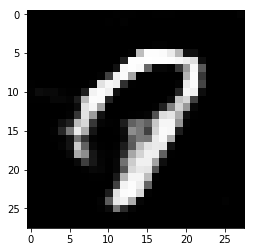

Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 0.7587


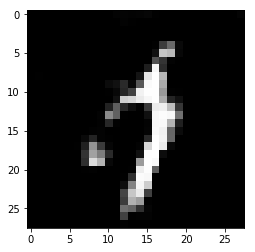

Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 2.3085


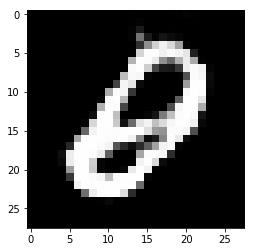

Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 2.0394


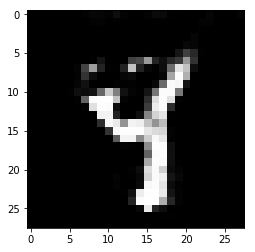

Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 0.6354


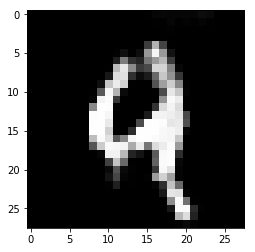

Epoch 2/2... Discriminator Loss: 2.0957... Generator Loss: 0.2176


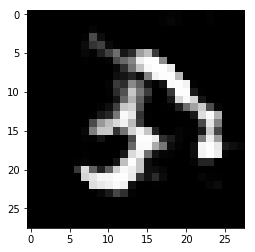

Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.2330


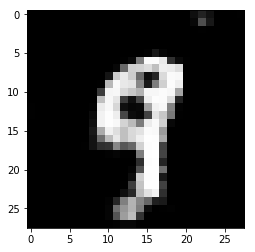

Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.9403


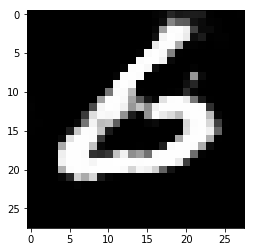

Epoch 2/2... Discriminator Loss: 1.4491... Generator Loss: 0.3777


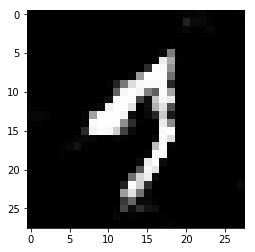

Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.4814


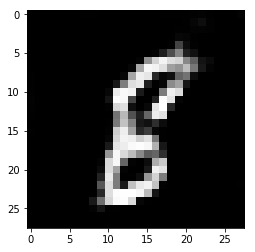

Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.5622


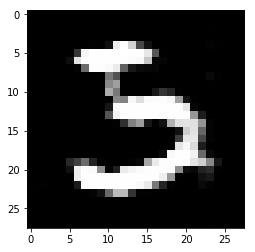

Epoch 2/2... Discriminator Loss: 1.9681... Generator Loss: 0.2413


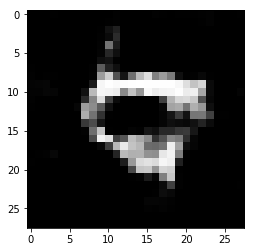

Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 0.8489


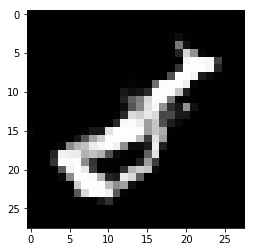

Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 0.9163


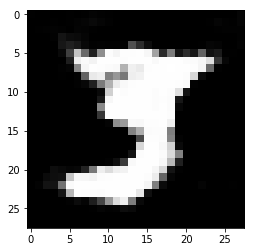

Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 0.8691


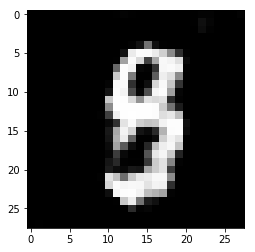

Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 0.6968


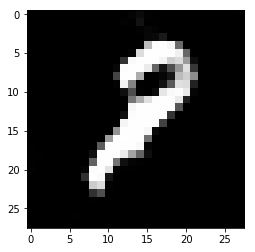

Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.7190


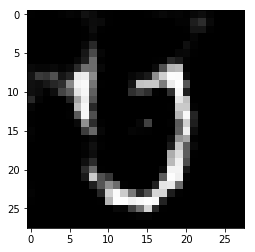

Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 0.8695


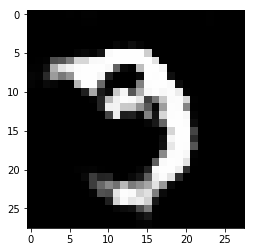

Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 1.2470


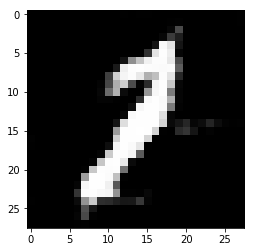

Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 0.7694


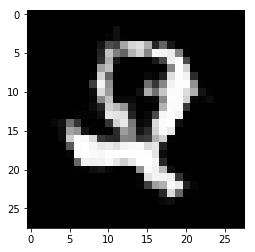

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.2566


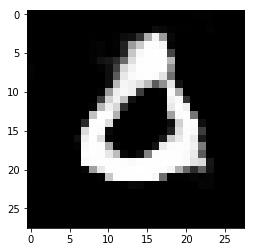

Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.7416


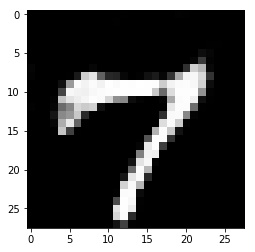

Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.0591


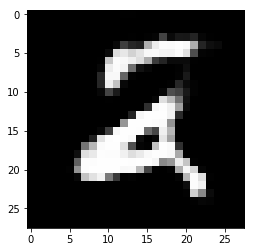

Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 0.6918


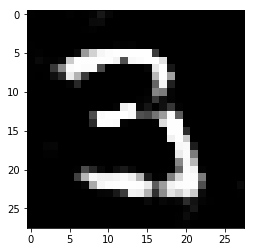

Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 1.1012


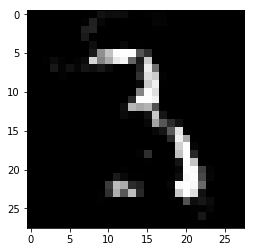

Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 0.9980


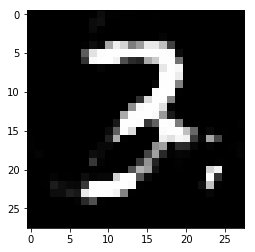

Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.5661


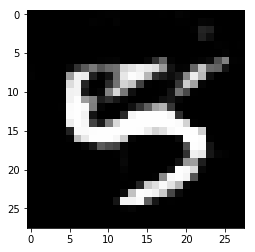

Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.5991


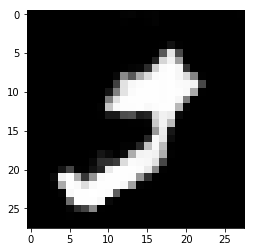

Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.3416


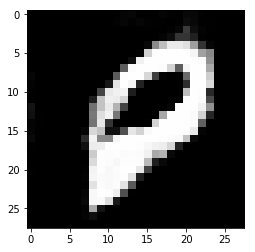

Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 0.8593


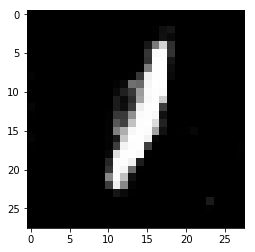

Epoch 2/2... Discriminator Loss: 0.5135... Generator Loss: 1.5907


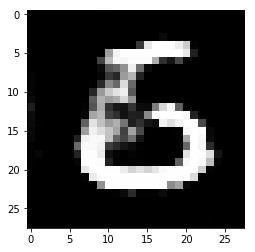

Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.2996


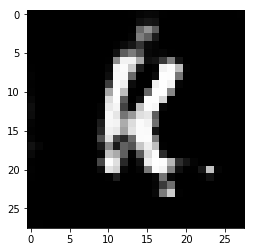

Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 1.1028


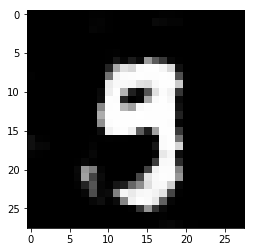

Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.4855


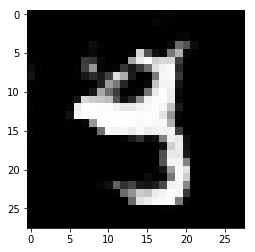

Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.5857


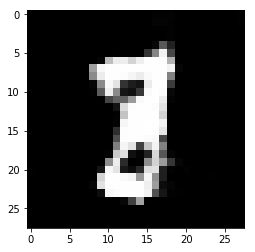

Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 1.7464


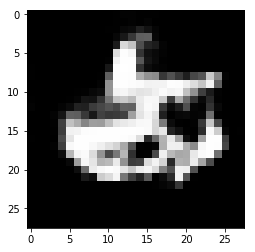

Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.5712


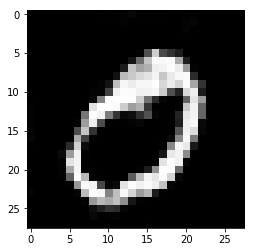

Epoch 2/2... Discriminator Loss: 1.9953... Generator Loss: 3.3251


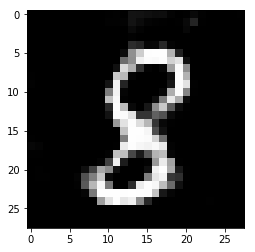

Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 2.5737


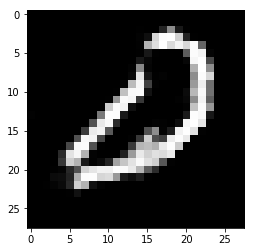

Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.9702


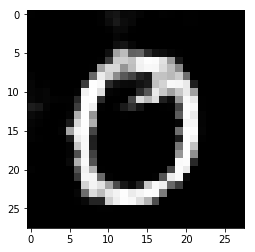

Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 2.7181


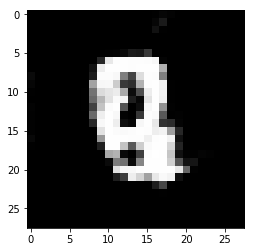

Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 1.0377


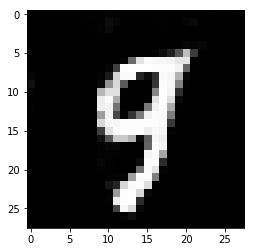

Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.6917


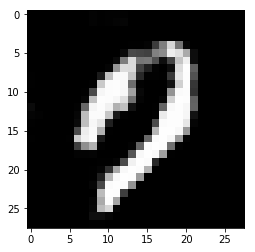

Epoch 2/2... Discriminator Loss: 1.6076... Generator Loss: 0.4170


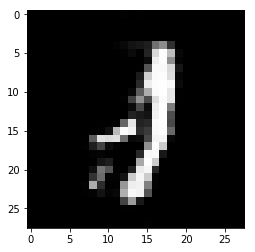

Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 0.9326


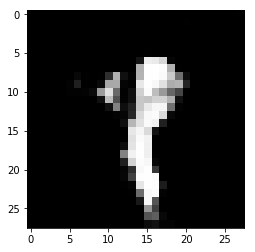

Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 0.8156


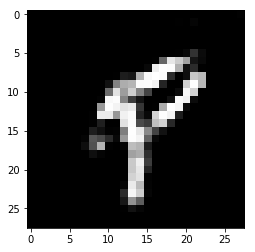

Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 0.9446


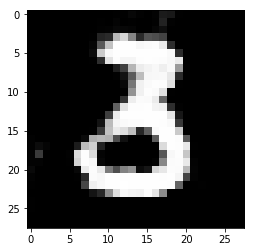

Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.1882


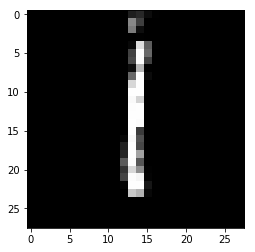

Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 0.8011


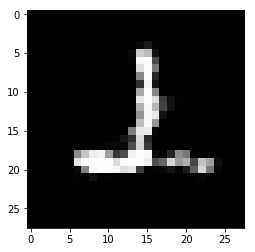

Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.7867


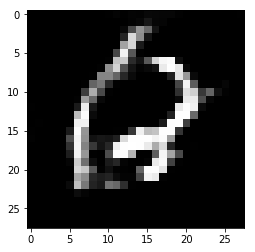

Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 0.8219


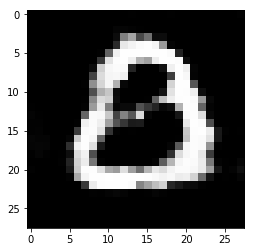

Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.2055


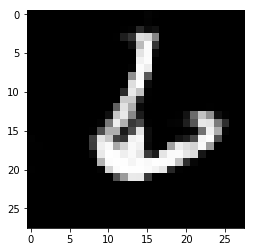

Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.6248


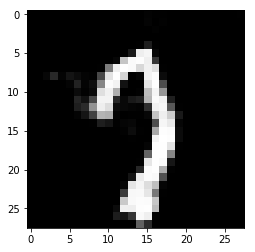

Epoch 2/2... Discriminator Loss: 0.6064... Generator Loss: 1.5294


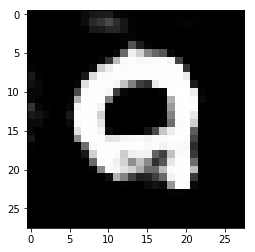

Epoch 2/2... Discriminator Loss: 0.6050... Generator Loss: 1.6824


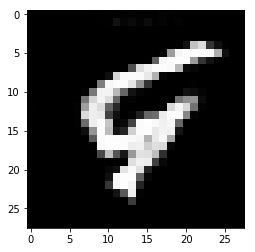

Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 0.9623


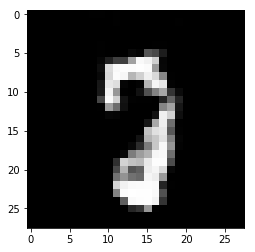

Epoch 2/2... Discriminator Loss: 1.4373... Generator Loss: 0.4504


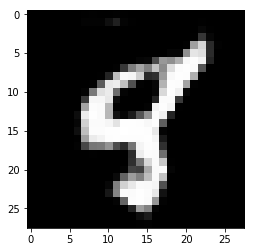

Epoch 2/2... Discriminator Loss: 1.4666... Generator Loss: 0.3999


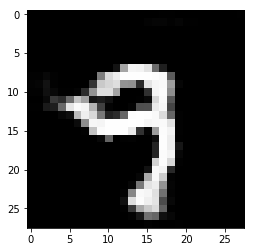

Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.7609


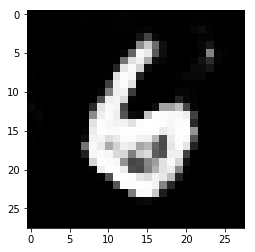

Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.5432


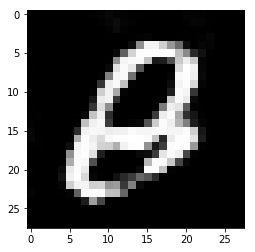

Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 0.9954


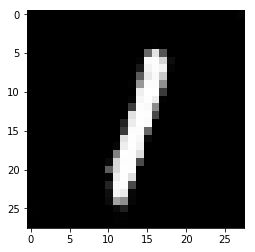

Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 0.9368


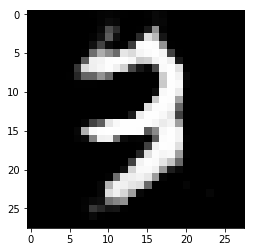

Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.3462


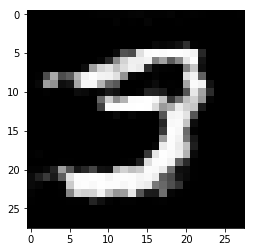

Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 1.5155


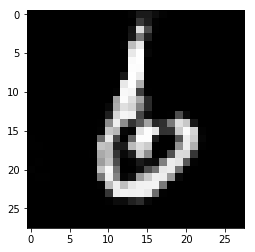

Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 1.1077


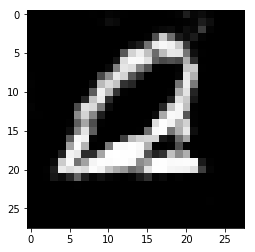

Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 1.0285


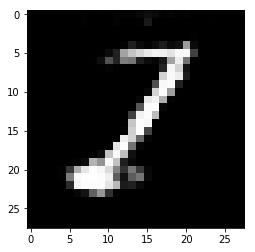

Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.1190


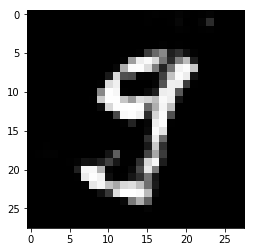

Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.6121


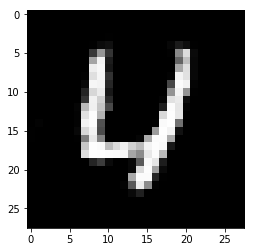

Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 0.8679


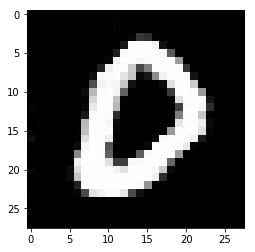

Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 1.3287


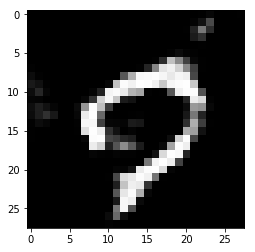

Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 4.2581


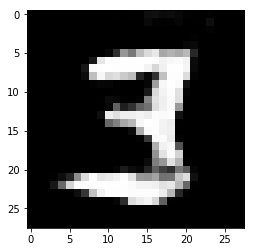

Epoch 2/2... Discriminator Loss: 0.6590... Generator Loss: 1.8495


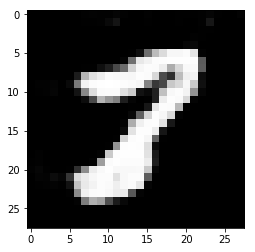

Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 0.9806


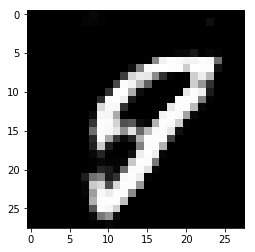

Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.8374


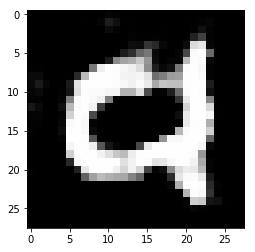

Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 1.6478


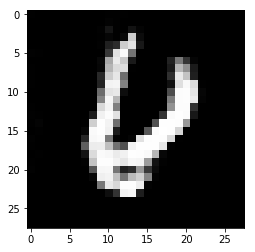

Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.5294


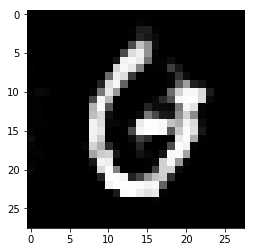

Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 0.9573


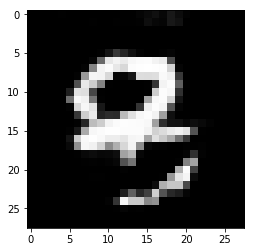

Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 3.6680


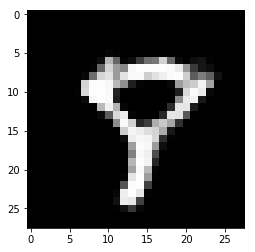

Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 1.1947


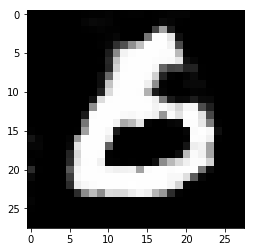

Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.6020


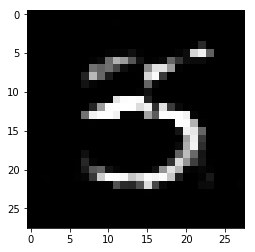

Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.6543


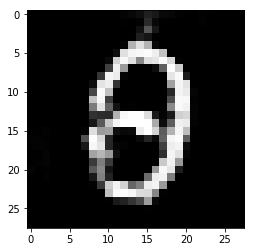

Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 0.7235


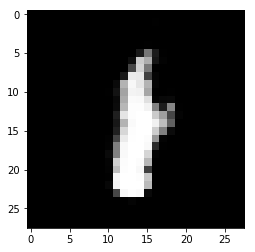

In [81]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2021... Generator Loss: 16.3418


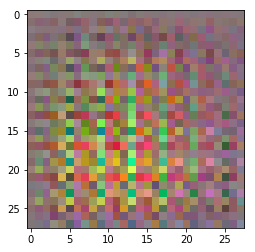

Epoch 1/1... Discriminator Loss: 0.1150... Generator Loss: 3.2208


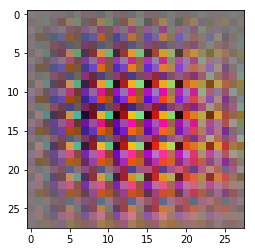

Epoch 1/1... Discriminator Loss: 2.5579... Generator Loss: 0.1385


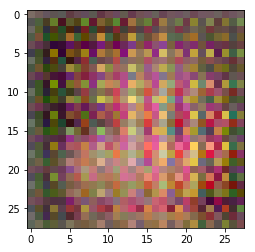

Epoch 1/1... Discriminator Loss: 0.1251... Generator Loss: 5.3801


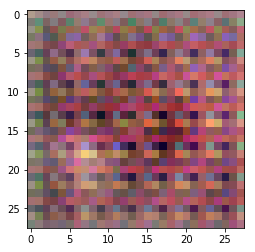

Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 4.3316


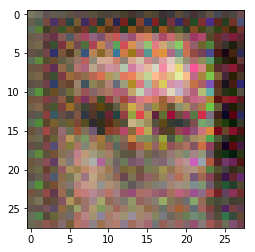

Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.8029


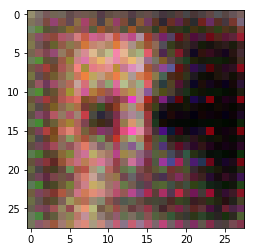

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7014


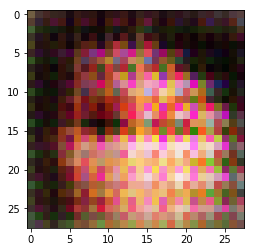

Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8133


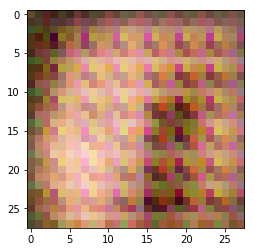

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.4786


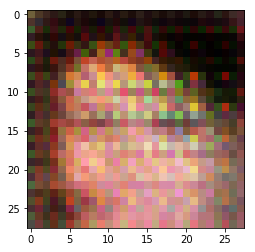

Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.5534


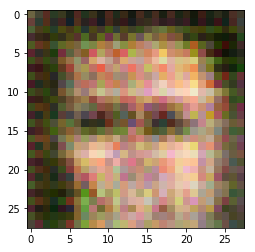

Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.8283


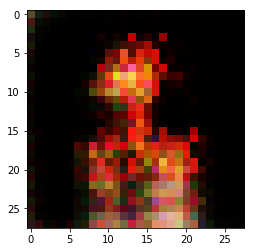

Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 2.2159


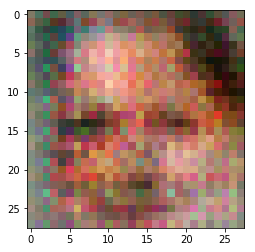

Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.8297


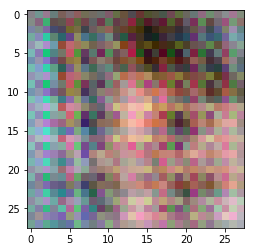

Epoch 1/1... Discriminator Loss: 1.7348... Generator Loss: 0.2837


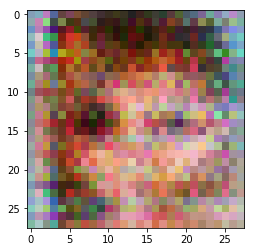

Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.7011


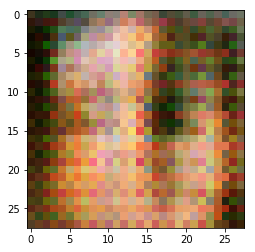

Epoch 1/1... Discriminator Loss: 1.9163... Generator Loss: 4.9218


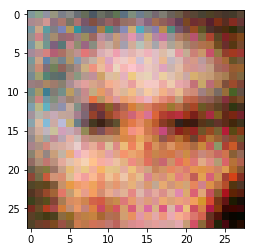

Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.1107


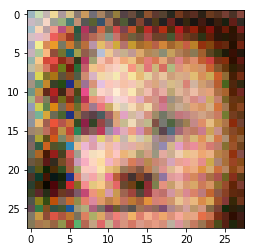

Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.0758


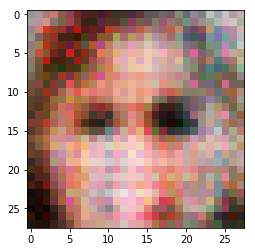

Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.9818


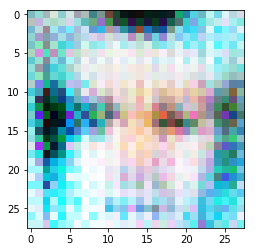

Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.9913


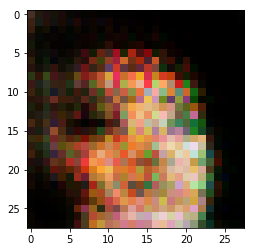

Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.5145


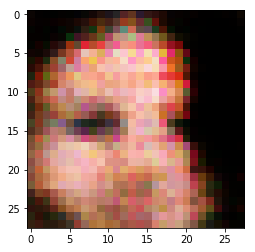

Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.9215


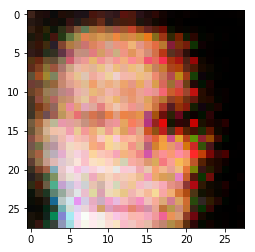

Epoch 1/1... Discriminator Loss: 3.1645... Generator Loss: 0.0935


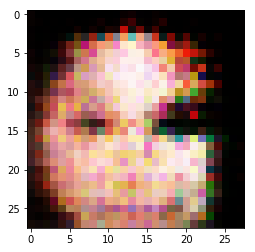

Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 0.8222


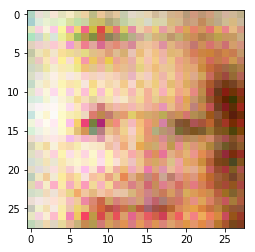

Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.1070


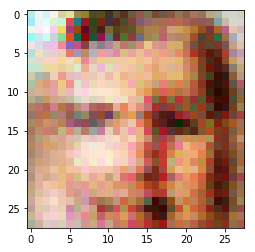

Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.9706


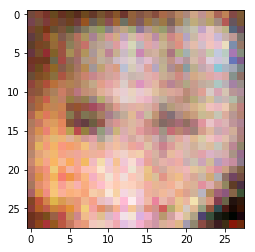

Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.1114


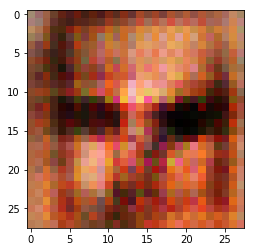

Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.0505


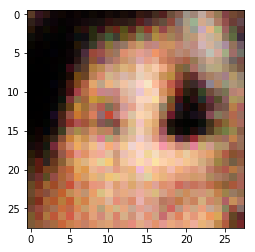

Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.9038


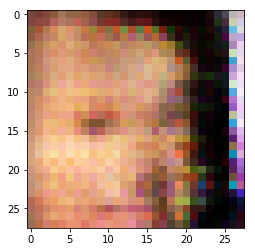

Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.1346


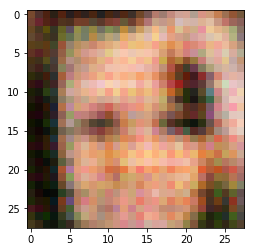

Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.2024


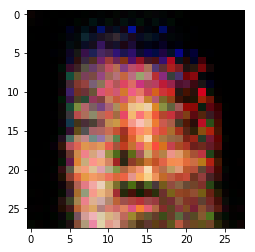

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.9106


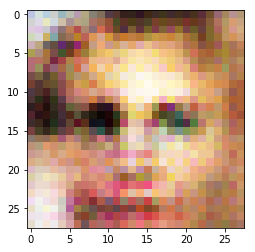

Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 0.8440


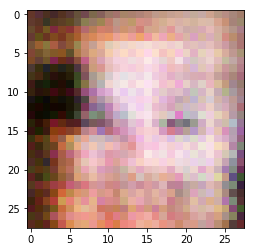

Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.3934


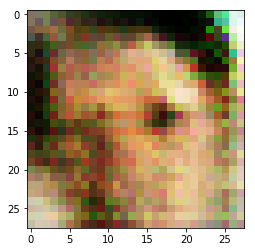

Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.3264


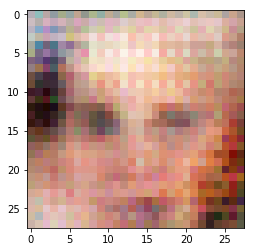

Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.4869


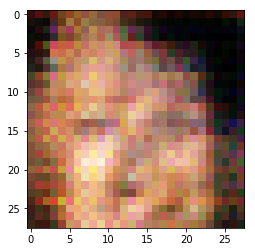

Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.3728


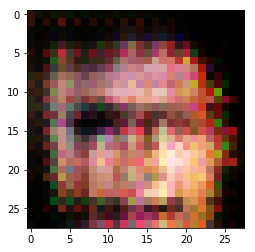

Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.5555


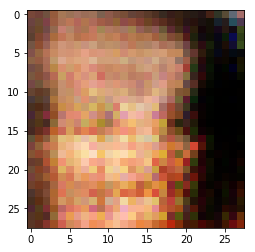

Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.3722


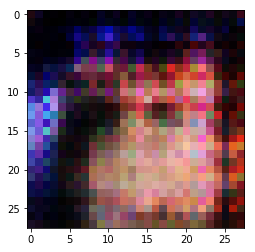

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8268


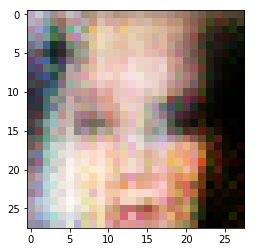

Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.2504


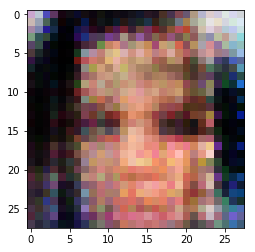

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 2.4240


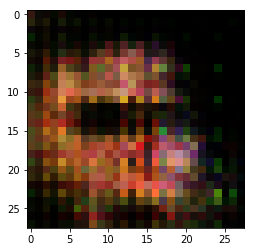

Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.5374


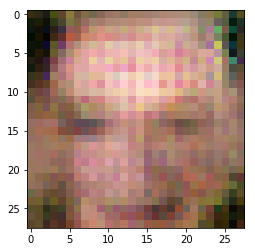

Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 0.8065


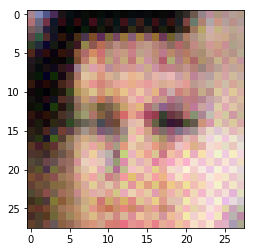

Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.7473


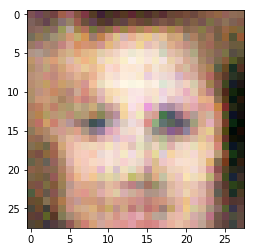

Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.1283


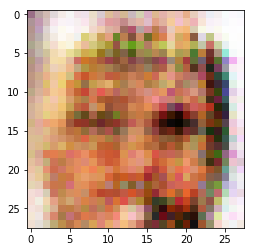

Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.2619


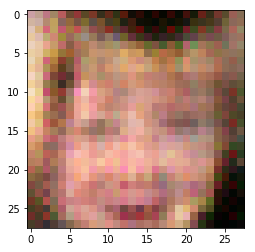

Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 0.8752


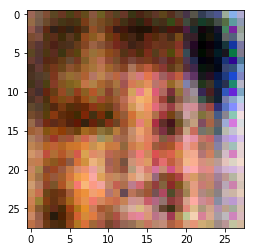

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.3679


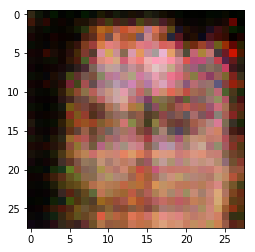

Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.0880


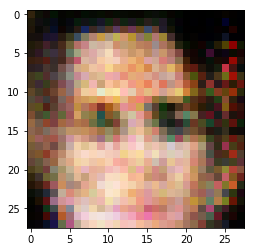

Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.0153


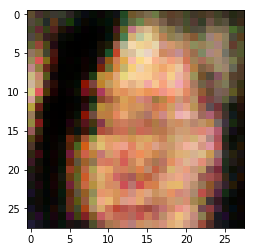

Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7989


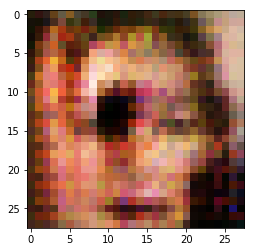

Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 0.8623


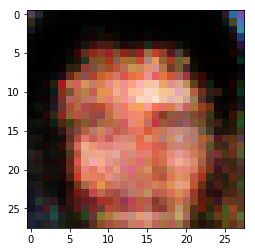

Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.9095


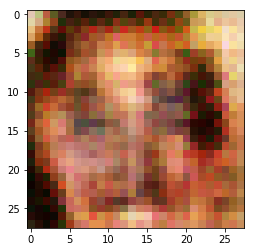

Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 1.0729


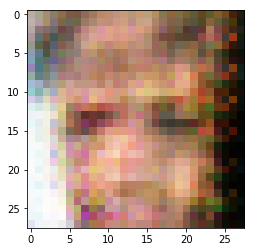

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.5967


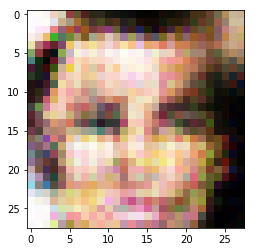

Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.2530


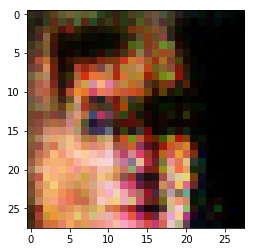

Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.9513


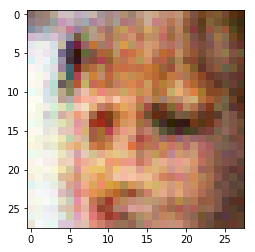

Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.7349


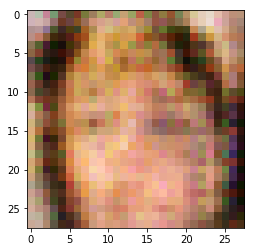

Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 2.0236


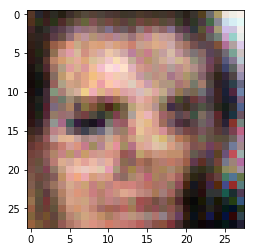

Epoch 1/1... Discriminator Loss: 1.8262... Generator Loss: 0.2703


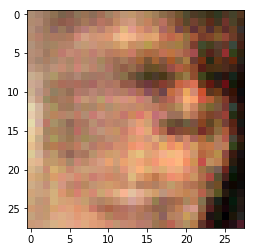

Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.2832


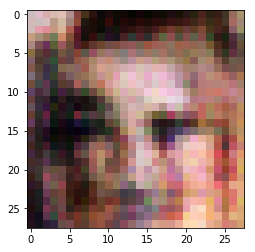

Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.9348


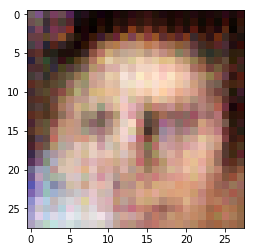

Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.5641


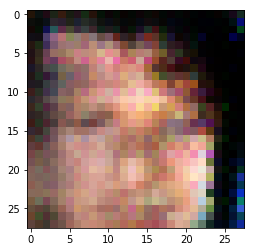

Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.3545


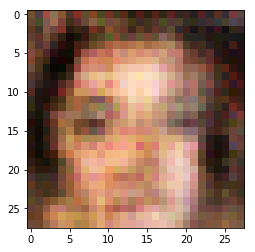

Epoch 1/1... Discriminator Loss: 1.9134... Generator Loss: 2.0480


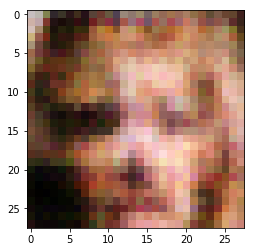

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.9868


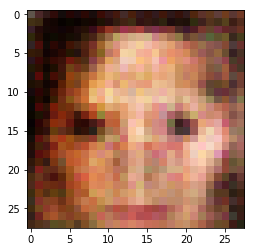

Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.2103


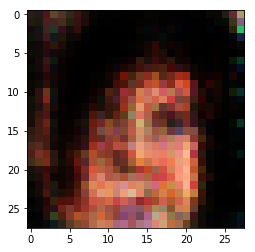

Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.3964


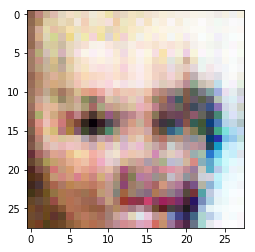

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.4826


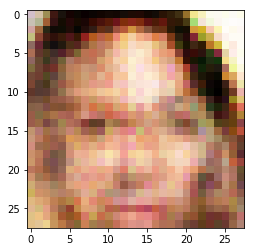

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.6724


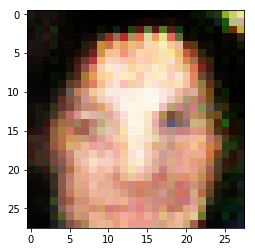

Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.2939


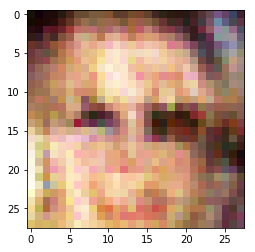

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9570


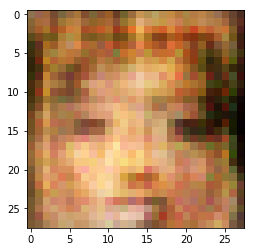

Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0563


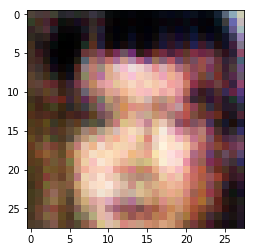

Epoch 1/1... Discriminator Loss: 1.8252... Generator Loss: 0.2834


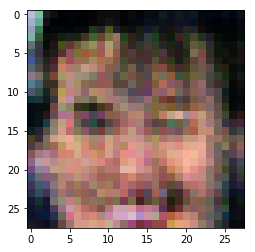

Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.3275


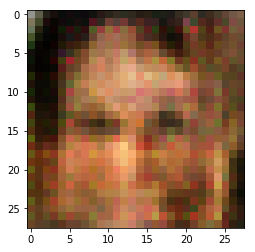

Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.4702


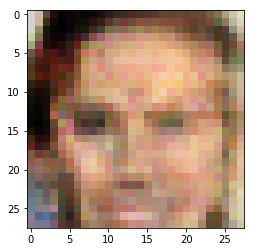

Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.0163


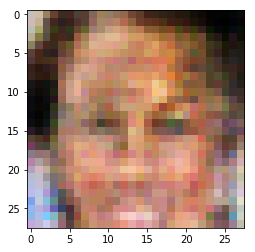

Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.0227


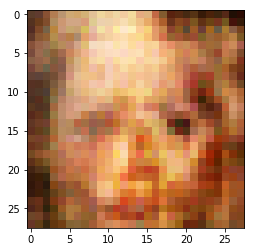

In [90]:
batch_size = 256
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.